# Problem Statement

FNC-1 was designed as a stance detection dataset and it contains 75,385 labeled headline and article pairs. The pairs are labelled as either agree, disagree, discuss, and unrelated. Each headline in the dataset is phrased as a statement



# Importing Libraries

In [41]:
import pandas as pd
import numpy as np
import os
import keras
print(keras.__version__)

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.utils import to_categorical, plot_model

from tensorflow.keras.layers import Input, LSTM, Embedding, Dropout, Activation, Reshape, Dense, GRU, Add, Flatten, concatenate
from tensorflow.keras.models import Model, Sequential


# from keras.preprocessing.sequence import pad_sequences
# from keras.preprocessing.text import Tokenizer
# from keras.utils import to_categorical,plot_model

# from keras.models import Input,Model,Sequential
# from keras.layers import LSTM,Embedding,Dropout,Activation,Reshape,Dense,GRU,Add,Flatten,concatenate

# from keras.preprocessing.text import one_hot
# from keras.preprocessing.sequence import pad_sequences


3.2.0


# Dataset Preparation

In [42]:
data = pd.read_csv("./dataset/lemmatized_dataset_final.csv")

In [43]:
data['stance_cat'] = data['Stance'].map({'agree':0,'disagree':1,'discuss':2,'unrelated':3}).astype(int)
data['Stance'].value_counts()
#'agree':0,'disagree':1,'discuss':2,'unrelated':3

Stance
unrelated    36545
discuss       8909
agree         3678
disagree       840
Name: count, dtype: int64

In [44]:
#details of corpus

corpus = np.r_[data['Headline'].values,data['articleBody'].values]
print(len(corpus)) # first 49972 contains the Headline and next 49972 contains the articleBody

vocabulary = []
for sentence in corpus:
    vocabulary.extend(sentence.split(' '))

vocabulary = list(set(vocabulary))
vocab_length = len(vocabulary)
print("Vocabulary Length is {0}".format(vocab_length))


99944
Vocabulary Length is 23422


In [45]:
data.head()

,Headline,Body ID,Stance,articleBody,stance_cat
0,police find mass graf with at least 15 body ne...,712,unrelated,danny boyle is directing the untitled film set...,3
1,hundred of palestinian flee flood in gaza a is...,158,agree,hundred of palestinian were evacuated from the...,0
2,christian bale pass on role of steve job actor...,137,unrelated,30yearold moscow resident wa hospitalized with...,3
3,hbo and apple in talk for 15month apple tv str...,1034,unrelated,reuters a canadian soldier wa shot at the cana...,3
4,spider burrowed through tourist stomach and up...,1923,disagree,fear not arachnophobes the story of bunburys s...,1


# BASELINE - ONE HOT ENCODING

In [46]:
max_features = 5000
max_nb_words = 24000
EMBEDDING_DIM = 50
MAX_SEQUENCE_LENGTH_HEADLINE = 64
MAX_SEQUENCE_LENGTH_BODY = 64

In [47]:

encoded_docs_headline = [one_hot(sentence,vocab_length) for sentence in data.loc[:,'Headline'].tolist()]
padded_docs_headline = pad_sequences(encoded_docs_body,MAX_SEQUENCE_LENGTH_HEADLINE,padding='post')

encoded_docs_body = [one_hot(sentence,vocab_length) for sentence in data.loc[:,'articleBody'].tolist()]
padded_docs_body = pad_sequences(encoded_docs_body,MAX_SEQUENCE_LENGTH_BODY,padding='post')


labels = to_categorical(data.loc[:,'stance_cat'])


In [48]:
padded_docs_headline_train = padded_docs_headline[:int(len(padded_docs_headline)*0.8),:]
padded_docs_headline_test = padded_docs_headline[int(len(padded_docs_headline)*0.8):,:]

padded_docs_body_train = padded_docs_body[:int(len(padded_docs_body)*0.8),:]
padded_docs_body_test = padded_docs_body[int(len(padded_docs_body)*0.8):,:]

labels_train = labels[:int(len(labels)*0.8),:]
labels_test = labels[int(len(labels)*0.8):,:]


In [49]:
# Assuming you have your data loaded and processed, and your model is defined as 'model_combined'

# Split the data into training, validation, and test sets
split_index_train = int(len(padded_docs_headline) * 0.8)
split_index_val = int(len(padded_docs_headline) * 0.9)

padded_docs_headline_train = padded_docs_headline[:split_index_train]
padded_docs_headline_val = padded_docs_headline[split_index_train:split_index_val]
padded_docs_headline_test = padded_docs_headline[split_index_val:]

padded_docs_body_train = padded_docs_body[:split_index_train]
padded_docs_body_val = padded_docs_body[split_index_train:split_index_val]
padded_docs_body_test = padded_docs_body[split_index_val:]

labels_train = labels[:split_index_train]
labels_val = labels[split_index_train:split_index_val]
labels_test = labels[split_index_val:]



# Defining Model Architecture

In [60]:
from keras.layers import Bidirectional
from tensorflow.keras.layers import Input, Embedding, Dropout, Conv1D, MaxPooling1D, concatenate, Dense, Flatten


############### HEADLINE ##################
input_headline = Input(shape=[64], name='input_headline')
embedding_headline = Embedding(vocab_length, 50, input_length=MAX_SEQUENCE_LENGTH_HEADLINE)(input_headline)

# Dropout after embedding
dropout_headline = Dropout(0.5)(embedding_headline)

# CNN
conv_headline_1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(dropout_headline)
pool_headline_1 = MaxPooling1D(pool_size=2)(conv_headline_1)
conv_headline_2 = Conv1D(filters=64, kernel_size=4, activation='relu', padding='same')(dropout_headline)
pool_headline_2 = MaxPooling1D(pool_size=2)(conv_headline_2)
conv_headline_3 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(dropout_headline)
pool_headline_3 = MaxPooling1D(pool_size=2)(conv_headline_3)
cnn_concatenated_headline = concatenate([pool_headline_1, pool_headline_2, pool_headline_3], axis=-1)
# bi lstm
lstm_headline = Bidirectional(LSTM(units=64))(cnn_concatenated_headline)
#############################################

####################### BODY ###########################
input_body = Input(shape=[64], name='input_body')
embedding_body = Embedding(vocab_length, 50, input_length=MAX_SEQUENCE_LENGTH_BODY)(input_body)

# Dropout after embedding
dropout_body = Dropout(0.5)(embedding_body)

# CNN
conv_body_1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(dropout_body)
pool_body_1 = MaxPooling1D(pool_size=2)(conv_body_1)
conv_body_2 = Conv1D(filters=64, kernel_size=4, activation='relu', padding='same')(dropout_body)
pool_body_2 = MaxPooling1D(pool_size=2)(conv_body_2)
conv_body_3 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(dropout_body)
pool_body_3 = MaxPooling1D(pool_size=2)(conv_body_3)
cnn_concatenated_body = concatenate([pool_body_1, pool_body_2, pool_body_3], axis=-1)
# bi lstm
lstm_body = Bidirectional(LSTM(units=64))(cnn_concatenated_body)
########################################################

# final hybrid
hybrid = concatenate([lstm_headline, lstm_body])
dropout_hybrid = Dropout(0.8)(hybrid)
output = Dense(4, activation='softmax')(dropout_hybrid)
# output = Dense(4, activation='sigmoid')(dropout_hybrid)

model_combined = Model(inputs=[input_headline, input_body], outputs=output)
model_combined.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


c:\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# Model Architecture

In [61]:
model_combined.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_headline      │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_body          │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_12        │ (None, 64, 50)    │  1,171,100 │ input_headline[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_13        │ (None, 64, 50)    │  1,171,100 │ input_body[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 64, 50)    │          0 │ embedding_12[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 64, 50)    │          0 │ embedding_13[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 64, 64)    │      9,664 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 64, 64)    │     12,864 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 64, 64)    │     16,064 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 64, 64)    │      9,664 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 64, 64)    │     12,864 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 64, 64)    │     16,064 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_30    │ (None, 32, 64)    │          0 │ conv1d_30[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_31    │ (None, 32, 64)    │          0 │ conv1d_31[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_32    │ (None, 32, 64)    │          0 │ conv1d_32[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_33    │ (None, 32, 64)    │          0 │ conv1d_33[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_34    │ (None, 32, 64)    │          0 │ conv1d_34[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_35    │ (None, 32, 64)    │          0 │ conv1d_35[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 32, 192)   │          0 │ max_pooling1d_30

 Total params: 2,683,580 (10.24 MB)

 Trainable params: 2,683,580 (10.24 MB)

 Non-trainable params: 0 (0.00 B)

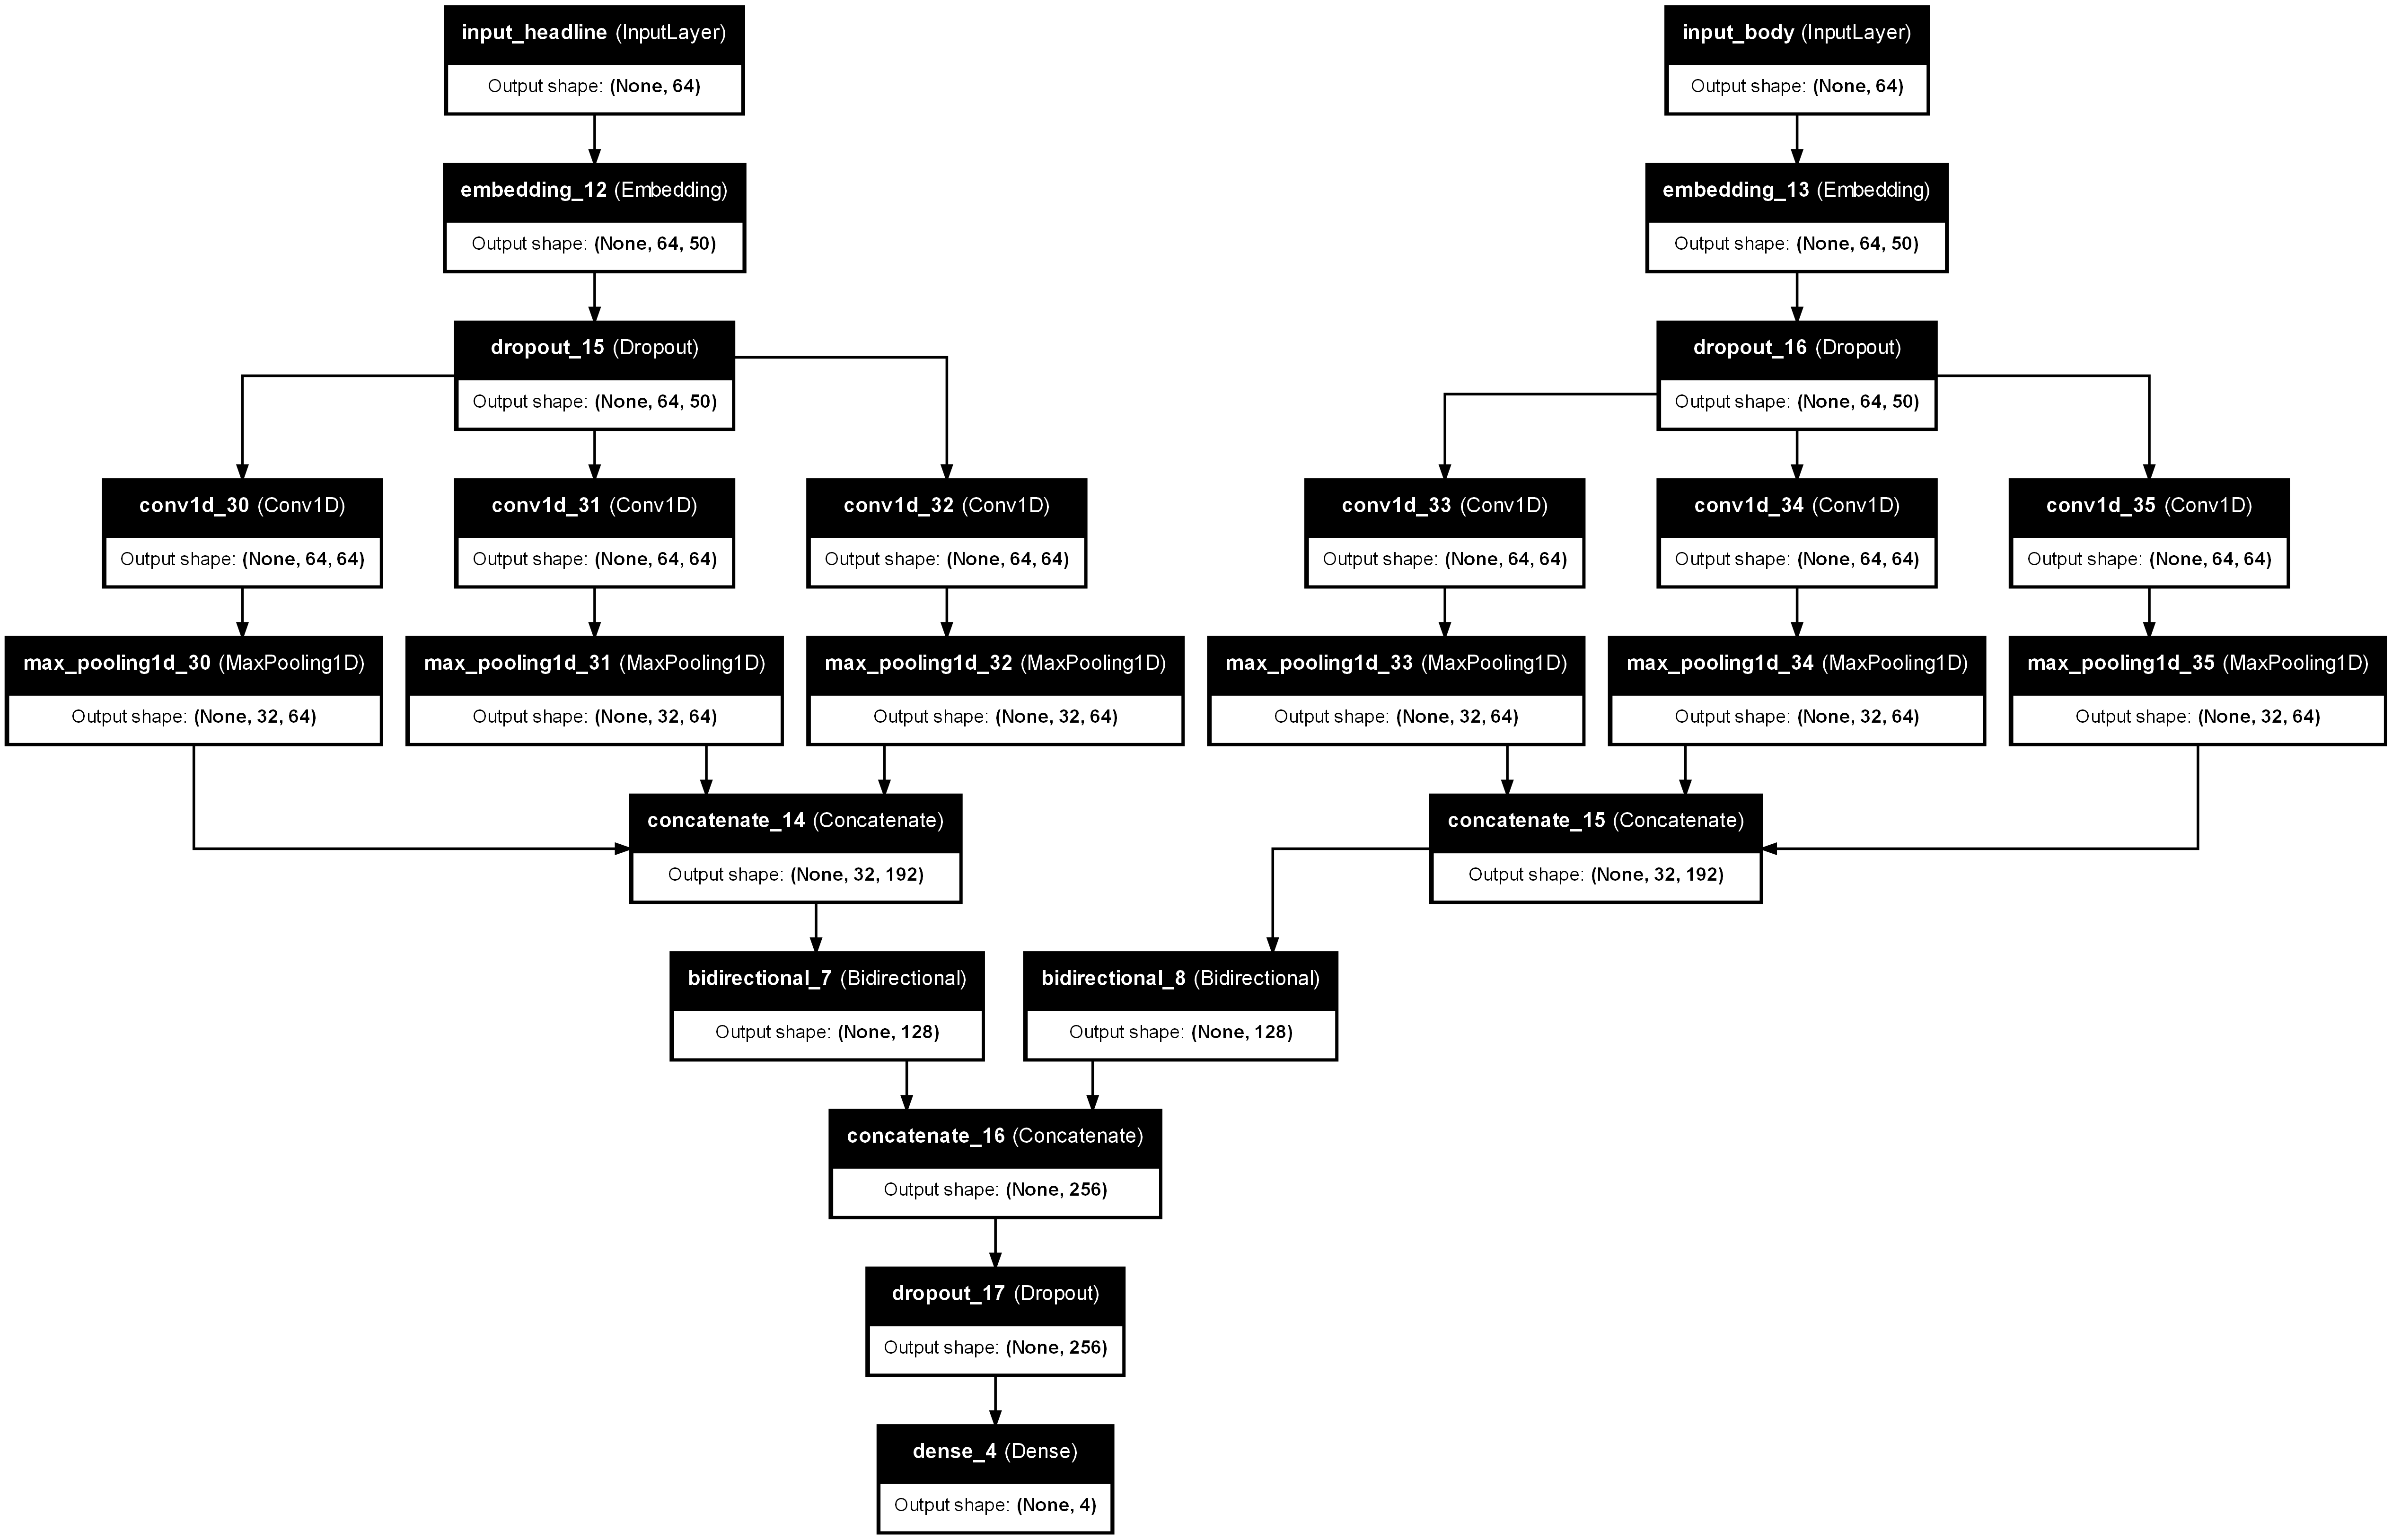

In [62]:
plot_model(model_combined, to_file='model_one_hot.png', show_shapes=True, show_layer_names=True)


# Model Training

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 64s 44ms/step - accuracy: 0.7400 - loss: 0.7682 - val_accuracy: 0.8021 - val_loss: 0.5557
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - accuracy: 0.7971 - loss: 0.5640 - val_accuracy: 0.8067 - val_loss: 0.5308
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 53s 42ms/step - accuracy: 0.8108 - loss: 0.5236 - val_accuracy: 0.8123 - val_loss: 0.5160
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - accuracy: 0.8114 - loss: 0.5073 - val_accuracy: 0.8071 - val_loss: 0.5215
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 56s 45ms/step - accuracy: 0.8140 - loss: 0.5018 - val_accuracy: 0.8145 - val_loss: 0.5055
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 65s 52ms/step - accuracy: 0.8169 - loss: 0.4882 - val_accuracy: 0.8159 - val_loss: 0.5004
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 60s 48ms/step - accuracy: 0.8184 - loss: 0.4841 - val_accuracy: 0.8151 - val_loss: 0.5020
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 58s 47ms/step - accuracy: 0.8153 -

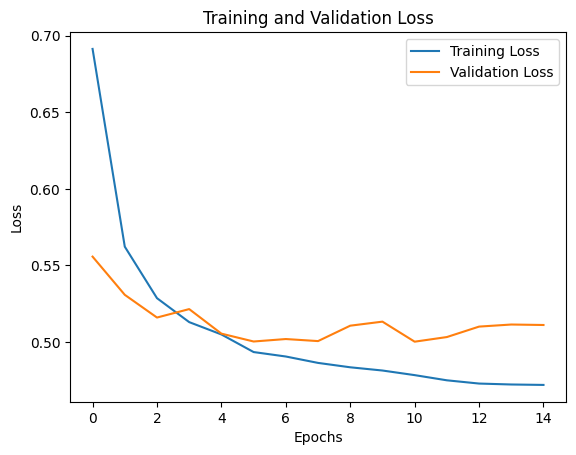

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8230 - loss: 0.5100
Test Loss: 0.5144486427307129
Test Accuracy: 0.8151260614395142


In [63]:
import matplotlib.pyplot as plt

# Train the model with training and validation sets
history = model_combined.fit([padded_docs_headline_train, padded_docs_body_train], labels_train, 
                              epochs=15, verbose=1, 
                              validation_data=([padded_docs_headline_val, padded_docs_body_val], labels_val),
                              )

# Save the training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the loss
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
loss, accuracy = model_combined.evaluate([padded_docs_headline_test, padded_docs_body_test], labels_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)



157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


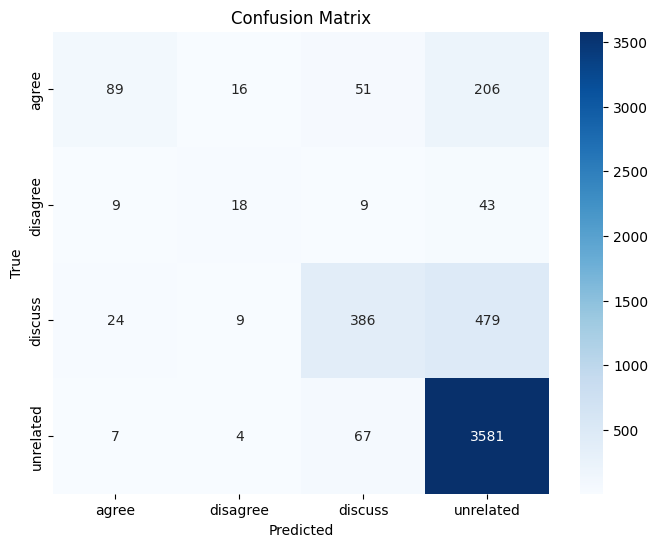

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming 'model_combined' is your trained model

# Get predictions on the test set
predictions = model_combined.predict([padded_docs_headline_test, padded_docs_body_test])
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(labels_test.argmax(axis=1), predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['agree', 'disagree', 'discuss', 'unrelated'],
            yticklabels=['agree', 'disagree', 'discuss', 'unrelated'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



In [65]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Calculate accuracy
RELATED = [0,1,2]
#'agree':0,'disagree':1,'discuss':2,'unrelated':3
accuracy = accuracy_score(labels_test.argmax(axis=1), predicted_labels)

# Calculate precision, recall, F1-score using scikit-learn
precision, recall, f1_score, _ = precision_recall_fscore_support(labels_test.argmax(axis=1), predicted_labels, average='weighted')

# Define your custom score function
def score_submission(gold_labels, test_labels):
    score = 0.0

    for i, (g, t) in enumerate(zip(gold_labels, test_labels)):
        g_stance, t_stance = g, t
        if g_stance == t_stance:
            score += 0.25
            if g_stance != 'unrelated':
                score += 0.50
        if g_stance in RELATED and t_stance in RELATED:
            score += 0.25


    return score


def report_score(actual,predicted):
    score = score_submission(actual,predicted)
    best_score = score_submission(actual,actual)

    print("Score: " +str(score) + " out of " + str(best_score) + "\t("+str(score*100/best_score) + "%)")
    return score*100/best_score


# Calculate your custom score
custom_score = score_submission(labels_test.argmax(axis=1), predicted_labels)
report_sc = report_score(labels_test.argmax(axis=1), predicted_labels)

# Print all the metrics
# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", f1_score)
print("Custom Score:", custom_score)


Score: 3208.25 out of 4083.25	(78.57099124471928%)
Custom Score: 3208.25


In [66]:
print(labels_test.argmax(axis=1))


[3 3 3 ... 0 2 3]


In [67]:
print(predicted_labels)

[3 3 3 ... 2 3 3]


In [68]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, F1-score for each class using scikit-learn
precision, recall, f1_score, _ = precision_recall_fscore_support(labels_test.argmax(axis=1), predicted_labels, average=None)

# Print class-wise F1 scores
for i in range(len(precision)):
    print(f"Class {i} - Precision: {precision[i]}, Recall: {recall[i]}, F1-score: {f1_score[i]}")

# Print all the metrics
print("Accuracy:", accuracy)
print("Macro Precision:", precision.mean())
print("Macro Recall:", recall.mean())
print("Macro F1 Score:", f1_score.mean())
print("Custom Score:", custom_score)


Class 0 - Precision: 0.689922480620155, Recall: 0.24585635359116023, F1-score: 0.3625254582484725
Class 1 - Precision: 0.3829787234042553, Recall: 0.22784810126582278, F1-score: 0.2857142857142857
Class 2 - Precision: 0.7524366471734892, Recall: 0.4298440979955457, F1-score: 0.5471296952515946
Class 3 - Precision: 0.8310512880018566, Recall: 0.9786827001913091, F1-score: 0.8988453815261044
Accuracy: 0.8151260504201681
Macro Precision: 0.664097284799939
Macro Recall: 0.47055781326095947
Macro F1 Score: 0.5235537051851142
Custom Score: 3208.25


**Please upvote the notebook if you find it useful**